![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

import xgboost as xgb

try:
    import panel as pn
except:
    !pip install panel
    import panel as pn

try: 
    import plotly.graph_objects as go
    import plotly.graph_objects as go
    import plotly.express as px
    import plotly.io as pio
    pn.extension('plotly')
except:
    !pip install plotly
    import plotly.graph_objects as go
    import plotly.graph_objects as go
    import plotly.express as px
    import plotly.io as pio
    pn.extension('plotly')

try: 
    from skopt import BayesSearchCV
except:
    ! pip install scikit-optimize
    from skopt import BayesSearchCV

In [3]:
# Bloque de funciones
paleta = ["#003f5c", "#2f4b7c", "#665191", "#a05195", "#d45087", "#f95d6a", "#ff7c43", "#ffa600"]

def histogramas (data):
    melted = data.melt(var_name='variable', value_name='value')
    grid=sns.FacetGrid(melted, col='variable', col_wrap=4, sharex=False, sharey=False, height=3)

    # Mapear la función de histograma a cada celda de la cuadricula
    grid.map(sns.histplot, 'value', kde=True, orientation='horizontal')

    # Ajustar el diseño y mostrar la figura
    plt.tight_layout()
    plt.show()

def compararModelos (models, data, score): 
    better = min(data)
    colores = ['#87CEEB' if value != better else '#6B8E23' for value in data]
    fig, ax = plt.subplots(figsize=(12,5))
    bar = ax.bar(models,data,linewidth=0.8, color=colores, edgecolor="silver")
    ax.set_title("Comparación del desempeño de los modelos")
    ax.set_xlabel("Descripción del modelo")
    ax.set_ylabel(score)
    bar_labels=[f'{value:,.0f}' for value in data]
    ax.bar_label(bar, bar_labels, label_type='center', padding=20)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_facecolor("whitesmoke")
    ax.spines["left"].set_color("gray")
    ax.spines["bottom"].set_color("gray")
    ax.tick_params(axis='x', labelsize=8)
    #ax.set_xticklabels(models, rotation=90)
    plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
    plt.tight_layout()
    plt.show()


def buildWidgets_df(name, df):
    data = list(df[name].unique())
    data = sorted(data, key=lambda x: (isinstance(x, int), x))
    control = pn.widgets.Select(name=name, value=data[0],
        options=data, sizing_mode='fixed', width=200)
    return control

def buildWidgets_list (name, list):
    data = list.copy()
    #data = sorted(data, key=lambda x: (isinstance(x, int), x))
    control = pn.widgets.Select(name=name, value=data[0],
        options=data, sizing_mode='fixed', width=200)
    return control

def chart001 (df, columnF1, columnF2, columnR1, columnR2, valueF=50, columnF3=None, valueF3=5, w=1000, h=600, paleta=paleta):
    
    des_variable=columnF1
    
    xtitle = columnR1
    ytitle = 'MSE'

    if columnF3 is None:
        df = df[(df[columnF2] == valueF)].sort_values(by=[columnR1, columnF1] , ascending=[True, True])
        titulo = f"MSE vs {columnR1}, with {columnF2}={valueF}"
    else:
        df = df[(df[columnF2] == valueF) & (df[columnF3] == valueF3)].sort_values(by=[columnR1, columnF1] , ascending=[True, True])
        titulo = f"MSE vs {columnR1}, with {columnF2}={valueF}, {columnF3}={valueF3}"

    fig = px.line(df, #y=df[columnR2], x=df[columnR1], #text=cod_agrupador, 
                  y=columnR2, x=columnR1,
                 color=columnF1, title=titulo, 
                 color_discrete_sequence=paleta, 
                 width=w, height=h
                )

    
    fig.update_layout(xaxis_tickformat=',.0f',
                      title_font=dict(size=14),
                      legend_font=dict(size=8), 
                      xaxis_title=xtitle,
                      yaxis_title=ytitle,
                      xaxis=dict(title_font=dict(size=10), tickfont=dict(size=8)),
                      yaxis=dict(title_font=dict(size=10), tickfont=dict(size=8)),
                      width=w, 
                      height=h,
                      legend=dict(
                                    orientation="h",
                                    yanchor="bottom",
                                    y=1.02,
                                    xanchor="right",
                                    x=1, 
                                    title=columnF1
                                    ),
                      margin=dict(l=50, r=20, t=120, b=10),
                      showlegend=True,
                      plot_bgcolor='#dddddd', 
                      #yaxis_gridcolor=colory, 
                      #xaxis_gridcolor=colorx,
  
    )
    
    return fig 

def update_param0 (event, p_list, df):
    param_sel = control00.value
    
    list_p = p_list.copy()
    list_p.remove(param_sel)
    control01.name, control01.options, control01.value = 'params 2', list_p, list_p[0]
    layout1[0][1] = control01
    data = list(df[list_p[1]].unique())
    data = sorted(data, key=lambda x: (isinstance(x, int), x))
    control02.name, control02.options, control02.value = list_p[1], data, data[0]
    layout1[0][2] = control02
    layout1[1][0].object = chart001 (df, control01.value, control02.name, param_sel, 'mean_test_score', control02.value)

def update_param1 (event, p_list, df):
    param_sel, param_values = control01.value, control01.options
    list_p = param_values.copy()
    list_p.remove(param_sel)
    data = list(df[list_p[0]].unique())
    data = sorted(data, key=lambda x: (isinstance(x, int), x))
    control02.name, control02.options, control02.value = list_p[0], data, data[0]
    layout1[1][0].object = chart001 (df, control01.value, control02.name, control00.value, 'mean_test_score', control02.value)
    
def update_param2 (event, p_list, df):
    layout1[1][0].object = chart001 (df, control01.value, control02.name, control00.value, 'mean_test_score', control02.value)

def update_param3 (event, p_list, df):
    param_sel = control03.value
    list_p = p_list.copy()
    list_p.remove(param_sel)
    control04.name, control04.options, control04.value = 'params 2', list_p, list_p[0]
    layout2[0][2] = control04
    data = list(df[list_p[1]].unique())
    data = sorted(data, key=lambda x: (isinstance(x, int), x))
    control05.name, control05.options, control05.value = list_p[1], data, data[0]
    layout2[0][3] = control05
    data = list(df[list_p[2]].unique())
    data = sorted(data, key=lambda x: (isinstance(x, int), x))
    control06.name, control06.options, control06.value = list_p[2], data, data[0]
    layout2[0][4] = control06
    layout2[1][0] = chart001 (df, control04.value, control05.name, control03.value, 'mean_test_score', control05.value, control06.name, control06.value)

def update_param4 (event, p_list, df):
    param_sel, param_values = control04.value, control04.options
    list_p = param_values.copy()
    list_p.remove(param_sel)
    data = list(df[list_p[0]].unique())
    data = sorted(data, key=lambda x: (isinstance(x, int), x))
    control05.name, control05.options, control05.value = list_p[0], data, data[0]
    layout2[0][3] = control05
    data = list(df[list_p[1]].unique())
    data = sorted(data, key=lambda x: (isinstance(x, int), x))
    control06.name, control06.options, control06.value = list_p[1], data, data[0]
    layout2[0][4] = control06
    layout2[1][0] = chart001 (df, control04.value, control05.name, control03.value, 'mean_test_score', control05.value, control06.name, control06.value)

def update_param5 (event, p_list, df):
    layout2[1][0] = chart001 (df, control04.value, control05.name, control03.value, 'mean_test_score', control05.value, control06.name, control06.value)
    
def update_param6 (event, p_list, df):
    layout2[1][0].object = chart001 (df, control04.value, control05.name, control03.value, 'mean_test_score', control05.value, control06.name, control06.value)

def update_param7(event, p_list, df):
    update_param3(event, p_list, df) 
    update_param4(event, p_list, df) 
    update_param5(event, p_list, df) 
    update_param6(event, p_list, df) 

In [4]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [5]:
# Los indices no son consecutivos, se resetearan para facilitar la seleccion de muestras por bagging
data= data.reset_index(drop=True)
data

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
0,21995,2014,6480,False,False,False,True,False,False,False
1,13995,2014,39972,False,False,False,False,True,False,False
2,17941,2016,18989,False,False,False,False,False,True,False
3,12493,2014,51330,False,False,False,True,False,False,False
4,7994,2007,116065,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
10490,20825,2017,7542,False,False,False,False,False,True,False
10491,12995,2014,49685,False,False,False,False,False,True,False
10492,8812,2009,104692,False,False,True,False,False,False,False
10493,11595,2010,105077,False,True,False,False,False,False,False


In [6]:
# Ver información básica del dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10495 entries, 0 to 10494
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  bool 
 4   M_Camry4dr   10495 non-null  bool 
 5   M_CamryBase  10495 non-null  bool 
 6   M_CamryL     10495 non-null  bool 
 7   M_CamryLE    10495 non-null  bool 
 8   M_CamrySE    10495 non-null  bool 
 9   M_CamryXLE   10495 non-null  bool 
dtypes: bool(7), int64(3)
memory usage: 317.8 KB


In [7]:
# Convertir boolean a integer
data[['M_Camry', 'M_Camry4dr', 
      'M_CamryBase', 'M_CamryL', 'M_CamryLE', 
      'M_CamrySE', 'M_CamryXLE']] = data[['M_Camry', 'M_Camry4dr', 
                                          'M_CamryBase', 'M_CamryL', 
                                          'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']].astype(int)

In [8]:
data.describe()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
count,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395,0.056313,0.158456,0.012292,0.048213,0.236494,0.376370,0.111863
std,3922.420961,3.116585,36791.736601,0.230535,0.365186,0.110189,0.214227,0.424949,0.484498,0.315213
min,5002.000000,1998.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11999.000000,2012.000000,26461.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,2014.000000,41680.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16999.000000,2016.000000,71355.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,32444.000000,2018.000000,232658.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


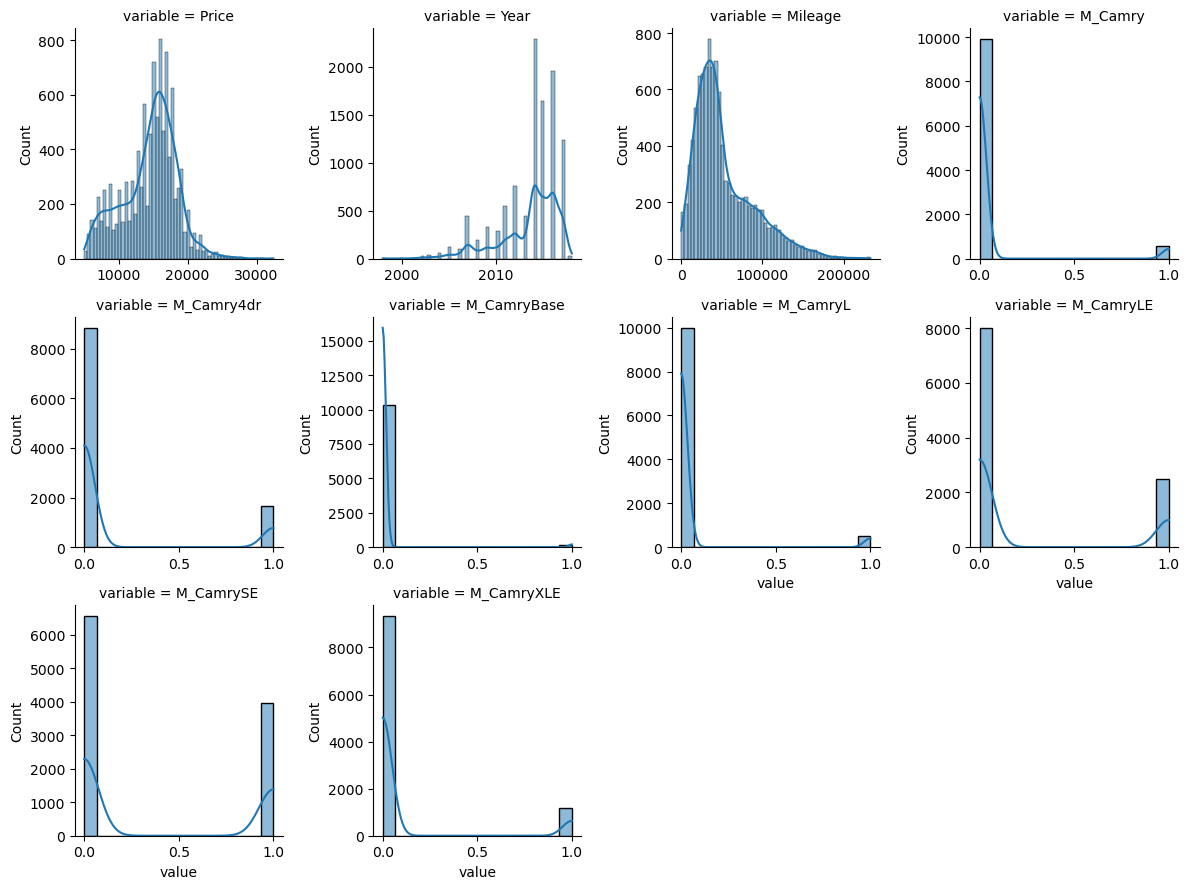

In [9]:
# realizar arrelo para crear histogramas de variables con fategrid
histogramas(data)

In [10]:
proporcion = data.iloc[:, 4:].mean()
proporcion

M_Camry4dr     0.158456
M_CamryBase    0.012292
M_CamryL       0.048213
M_CamryLE      0.236494
M_CamrySE      0.376370
M_CamryXLE     0.111863
dtype: float64

In [11]:
# Correlaciones
correlaciones=data.corr(numeric_only=True)
correlaciones

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
Price,1.000000,0.842194,-0.833761,-0.119099,-0.531215,-0.152627,0.008389,0.023929,0.327458,0.214611
Year,0.842194,1.000000,-0.765514,-0.230690,-0.567679,-0.149413,0.023512,0.132195,0.381565,0.097946
Mileage,-0.833761,-0.765514,1.000000,0.159758,0.510332,0.144638,-0.053071,-0.127897,-0.292463,-0.100622
M_Camry,-0.119099,-0.230690,0.159758,1.000000,-0.106000,-0.027251,-0.054980,-0.135954,-0.189772,-0.086694
M_Camry4dr,-0.531215,-0.567679,0.510332,-0.106000,1.000000,-0.048407,-0.097663,-0.241502,-0.337101,-0.154000
M_CamryBase,-0.152627,-0.149413,0.144638,-0.027251,-0.048407,1.000000,-0.025108,-0.062086,-0.086663,-0.039591
M_CamryL,0.008389,0.023512,-0.053071,-0.054980,-0.097663,-0.025108,1.000000,-0.125261,-0.174847,-0.079876
M_CamryLE,0.023929,0.132195,-0.127897,-0.135954,-0.241502,-0.062086,-0.125261,1.000000,-0.432362,-0.197518
M_CamrySE,0.327458,0.381565,-0.292463,-0.189772,-0.337101,-0.086663,-0.174847,-0.432362,1.000000,-0.275706
M_CamryXLE,0.214611,0.097946,-0.100622,-0.086694,-0.154000,-0.039591,-0.079876,-0.197518,-0.275706,1.000000


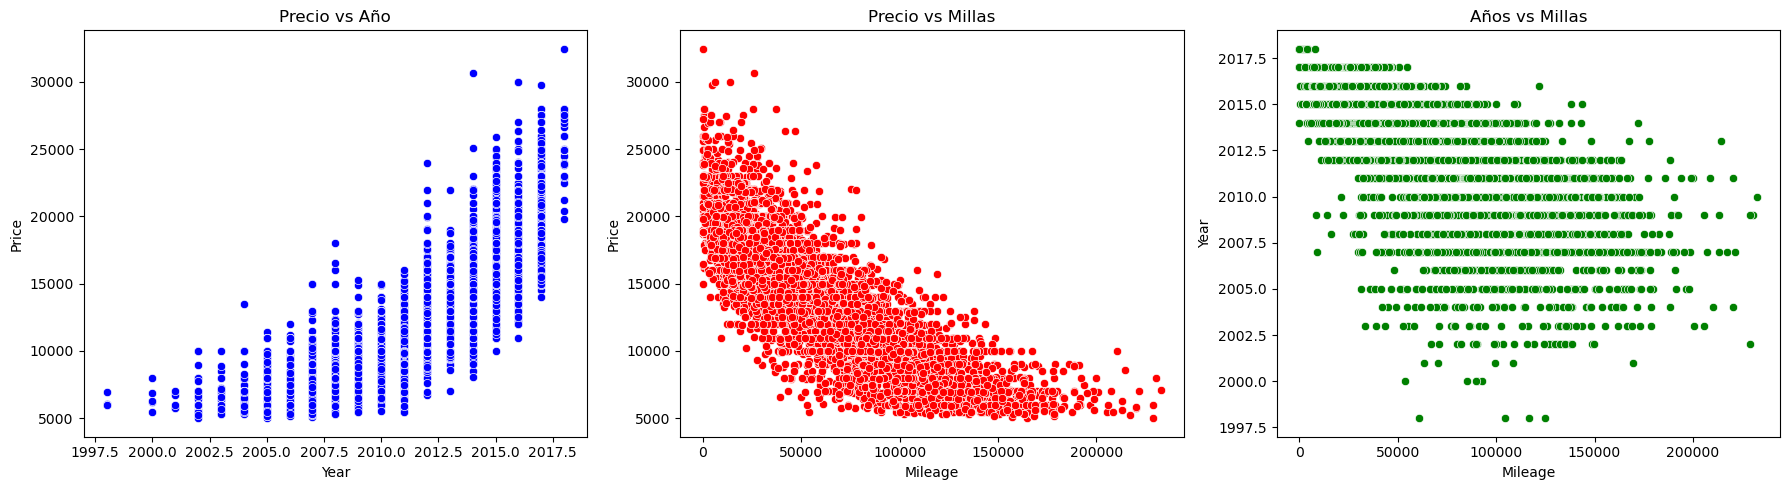

In [12]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='Year', y='Price', data=data, marker='o', color='blue')
plt.title('Precio vs Año')

plt.subplot(1, 3, 2)
sns.scatterplot(x='Mileage', y='Price', data=data, marker='o', color='red')
plt.title('Precio vs Millas')

plt.subplot(1, 3, 3)
sns.scatterplot(x='Mileage', y='Year', data=data, marker='o', color='green')
plt.title('Años vs Millas')

plt.tight_layout()
plt.show()

In [13]:
# Identificar correlaciones de mayor peso

umbral = 0.7
correlaciones_mayores = pd.DataFrame(correlaciones[((correlaciones>=umbral)&(correlaciones<1))| 
                                                   ((correlaciones<=-umbral)&(correlaciones>-1))])

f = 0

for index, row in correlaciones_mayores.iterrows():
    c = 0
    for column_name, value in row.items():
        
        if pd.notna(value):  # Verificar si el valor no es NaN
            if f<=c:
                print(f"{index} vs {column_name}, R2: {value:.4f}")
        c+=1
    f+=1

Price vs Year, R2: 0.8422
Price vs Mileage, R2: -0.8338
Year vs Mileage, R2: -0.7655


In [14]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data[['Price']]
X = data.drop(['Price'], axis=1)

In [15]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Hallazgos de la exploración preliminar de los datos
* El dataset contiene 10 variables, la variable a predecir 'Price' y nueve predictores. Siete de los nueve predictores son variables booleanas que corresponden a las variables dummy del modelo del vehiculo.  * Los indices del dataset no son consecutivos, por lo cual los reseteamos para obtener un indice consecutivo y prevenir errores al realizar el boostrap.
* 
Hay 10495 observaciones, no se identifican datos faltantes en ninguna de ellas.*  * 
El precio de venta tiene un promedio de 14,538 unidades monetarias, con un rango entre 5,002 y 32,444. El costo del 50% de los vehiculos se encuentran en el rango de 11,999 a 16,999 unidades monetars
* .
El año de los vehiculos oscila entre 1998 y 2018, y han recorrido en promedio 52,509 millas, con un rango entre 5 y 232,650 mis*
* El modelo qué se encuentra más dentro del dataset es el CamrySE, que representa un 37% de la muestra. s* . 
Ni la variable de salida, ni las variables predictoras no parecen seguir una distribución rm* a* l. 
Se identificó una alta correlación entre el precio del vehiculo y los predictores 'Year' y 'Mileage'. En ambos casos el R2 absoluto es superior a 0.8, siendo la correlación positiva con la variable 'Year' y negativa con la variable 'Mile Tambien existe una correlación importante, negativa, con un R2 superior a 0.7 entre años y millas. Estas correlaciones pueden interpretarse así:
    + Los vehiculos más nuevos tienen mayor precio.
    + A medida que aumenta el uso del vehículo en millas disminuye su precio.
    + Entre más nuevo sea el vehículo menos millas tendrá.ge'. 

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [17]:
# Celda 1
# Arreglo para almacenar resultados
model, rmse, mae, nt = [], [], [], []

# Ajustamos y_Train y y_Test a un dataframe con los mismos indices de X_Train y X_Test
y_Train = pd.DataFrame(y_train)
y_Train.index = X_train.index
y_Test = pd.DataFrame(y_test)
y_Test.index = X_test.index

X_train_array = X_train.to_numpy()
y_train_array = y_train.to_numpy()
X_test_array = X_test.to_numpy()

class NodoArbolDecision:
    total_nodos = 0  

    def __init__(self, profundidad=0, profundidad_max=10, numero_nodo=0):
        self.profundidad = profundidad
        self.profundidad_max = profundidad_max
        self.numero_nodo = numero_nodo
        self.es_hoja = False
        self.caracteristica_division = None
        self.umbral = None
        self.izquierda = None
        self.derecha = None
        self.prediccion = None
        NodoArbolDecision.total_nodos += 1  # Incrementar el contador de nodos cada vez que se crea un nodo

    def ajustar(self, X, y):
        if self.profundidad == self.profundidad_max or len(X) < 2:
            self.es_hoja = True
            self.prediccion = np.mean(y)
            return

        mejor_caracteristica, mejor_umbral = self.encontrar_mejor_division(X, y)

        if mejor_caracteristica is None:
            self.es_hoja = True
            self.prediccion = np.mean(y)
            return

        self.caracteristica_division = mejor_caracteristica
        self.umbral = mejor_umbral

        indices_izquierda = X[:, mejor_caracteristica] < mejor_umbral
        indices_derecha = X[:, mejor_caracteristica] >= mejor_umbral

        self.izquierda = NodoArbolDecision(self.profundidad + 1, self.profundidad_max, self.numero_nodo * 2 + 1)
        self.derecha = NodoArbolDecision(self.profundidad + 1, self.profundidad_max, self.numero_nodo * 2 + 2)

        self.izquierda.ajustar(X[indices_izquierda], y[indices_izquierda])
        self.derecha.ajustar(X[indices_derecha], y[indices_derecha])

    def encontrar_mejor_division(self, X, y):
        mejor_mse = float('inf')
        mejor_caracteristica = None
        mejor_umbral = None

        for indice_caracteristica in range(X.shape[1]):
            umbrales = np.unique(X[:, indice_caracteristica])
            for umbral in umbrales:
                indices_izquierda = X[:, indice_caracteristica] < umbral
                indices_derecha = X[:, indice_caracteristica] >= umbral

                if len(y[indices_izquierda]) < 1 or len(y[indices_derecha]) < 1:
                    continue

                mse = self.calcular_mse(y[indices_izquierda], y[indices_derecha])

                if mse < mejor_mse:
                    mejor_mse = mse
                    mejor_caracteristica = indice_caracteristica
                    mejor_umbral = umbral

        return mejor_caracteristica, mejor_umbral

    def calcular_mse(self, y_izquierda, y_derecha):
        media_izquierda = np.mean(y_izquierda)
        media_derecha = np.mean(y_derecha)
        mse_izquierda = np.mean((y_izquierda - media_izquierda) ** 2)
        mse_derecha = np.mean((y_derecha - media_derecha) ** 2)

        return (mse_izquierda * len(y_izquierda) + mse_derecha * len(y_derecha)) / (len(y_izquierda) + len(y_derecha))

    def predecir(self, X):
        if self.es_hoja:
            return np.array([self.prediccion] * len(X))

        indices = X[:, self.caracteristica_division] < self.umbral
        predicciones = np.empty(len(X))
        predicciones[indices] = self.izquierda.predecir(X[indices])
        predicciones[~indices] = self.derecha.predecir(X[~indices])

        return predicciones

In [21]:
# Construimos el árbol con los datos de entrenamiento y profundidad igual a 5
max_depth = 5
arbol = NodoArbolDecision(profundidad_max=max_depth)

# Hacemos predicciones sobre el conjunto de test
arbol.ajustar(X_train_array, y_train_array)
y_pred = arbol.predecir(X_test_array)

# Evaluamos el rendimiento del modelo
score1 = metrics.mean_squared_error(y_test, y_pred)
score2 = metrics.mean_absolute_error(y_test, y_pred)

# Contar el número de nodos finales en el árbol construido
print("Profundidad del árbol: ", max_depth) 
print("Número de nodos finales en el árbol:", NodoArbolDecision.total_nodos)

print("\nDesempeño en los datos de test")
print(f"mse: {score1:,.4f}")
print(f"mae: {score2:,.4f}")


Profundidad del árbol:  5
Número de nodos finales en el árbol: 189

Desempeño en los datos de test
mse: 2,963,987.5312
mae: 1,292.5821


###### Análisis e interpretación del Punto 1.  
* Usando el método 'train_test_split' dividimos la base de datos en datos de entrenamiento y pruebas, usaremos esta división en la ejecución de todos los modelos incluidos en el desarrollo de este taller. 
* Se programa y entrena un árbol de decisión manual con una profundidad máxima igual a 5; con la que se obtienen 126 nodos finales.
* Desde el punto de vista predictivo este árbol tiene los siguientes resultados: mse: 2,963,987.5312, 
mae: ,1292.5821;lo que nos puede decir que en promedio las predicciones se desvian 1721 del valor real. 9

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
num_trees = 10
predictions = np.zeros((len(X_test), num_trees))

for i in range(num_trees):
    # Crear un árbol de regresión
    tree1 = DecisionTreeRegressor(max_depth=max_depth)  
    # Seleccionar muestras de entrenamiento aleatorias con reemplazo (Bootstrap)
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    # Entrenar el árbol con las muestras seleccionadas
    tree1.fit(X_train.iloc[indices], y_train.iloc[indices])
    # Realizar predicciones en el conjunto de prueba
    y_predDTR = tree1.predict(X_test)
    predictions[:, i] = y_predDTR
    print(f'mse{i+1}: {metrics.mean_squared_error(y_test, y_predDTR)}')

# Promediar las predicciones de todos los árboles para obtener la predicción final
bagged_predictions = np.mean(predictions, axis=1)

In [ ]:
# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, bagged_predictions)
score2 = metrics.mean_absolute_error(y_test, bagged_predictions)


print("\nDesempeño en los datos de test")
print(f"mse: {score1:.4f}")
print(f"mae: {score2:.4f}")

model.append('Manual1 BaggingDecisionTreeClassifier max_depth=5, n_estimator=10, con estimador por libreria')
rmse.append(score1)
mae.append(score2)

In [ ]:
num_trees = 10
predictions = np.zeros((len(X_test), num_trees))

for i in range(num_trees):
    # Seleccionar muestras de entrenamiento aleatorias con reemplazo (Bootstrap)
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    # Crear y Entrenar el árbol con las muestras seleccionadas
    tree = build_tree(X_train.iloc[indices], y_train.iloc[indices], max_depth=max_depth)
    # Realizar predicciones en el conjunto de prueba
    y_predDTR = predict(tree, X_test)
    predictions[:, i] = y_predDTR
    print(f'mse{i+1}: {metrics.mean_squared_error(y_test, y_predDTR)}')

# Promediar las predicciones de todos los árboles para obtener la predicción final
bagged_predictions = np.mean(predictions, axis=1)

In [ ]:
# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, bagged_predictions)
score2 = metrics.mean_absolute_error(y_test, bagged_predictions)


print("\nDesempeño en los datos de test")
print(f"mse: {score1:.4f}")
print(f"mae: {score2:.4f}")

model.append('Manual2 BaggingDecisionTreeClassifier max_depth=5, n_estimator=10, con estimador manual')
rmse.append(score1)
mae.append(score2)

### Análisis e interpretación del Punto 2.  
* Realizamos dos procedimientos de bagging manual, el primero utilizando el estimador de árbol de decisión de la librería sklearn y el segundo utilizando el árbol manual que se construyo en el ejercicio anterior. 
* En cada caso creamos un procedimiento anidado para crear y entrenar, y realizar las predicciones 10 veces. Almacenamos cada una de las predicciones en un arreglo de np.array. Promediamos las 10 predicciones almanenadas en el np.array, para obtener la predicción final del ensamble con bagging, tanto para el caso que usa el árbol de decisión de sklearn como para el árbol de decisión manual .
* El desempeño predictivo del modelo con bagging manual y estimador de sklearn fue considerablemente mejor que el del modelo con el estimador manual, MSE: 2639683.2737 vs 6842651.5586; y MAE: 1210.6234 vs 2004.6494. 
* Conclusión: el bagging mejora la capacidad de predicción del modelo, en comparación de un árbol de decisión de regresión solo (tanto cuando se construyeron los árboles con el método manual, como cuando se hizo con el método de sklearn). 2

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3

# Definir el estimador base (en este caso, un árbol de regresión)
max_features = int(np.log(X_train.shape[1]))
print(f'max_features: {max_features}')
base_estimator = DecisionTreeRegressor(max_depth=max_depth, max_features=max_features)

num_trees = 10

# Crear el modelo Bagging con 10 árboles de regresión
bagging_regressor = BaggingRegressor(base_estimator=base_estimator, n_estimators=num_trees, random_state=42)

# Entrenar el modelo
bagging_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_Bagging = bagging_regressor.predict(X_test)

# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, y_pred_Bagging)
score2 = metrics.mean_absolute_error(y_test, y_pred_Bagging)


print("\nDesempeño en los datos de test")
print(f"mse: {score1:.4f}")
print(f"mae: {score2:.4f}")

model.append('BaggingDecisionTreeClassifier max_depth=5, n_estimator=10')
rmse.append(score1)
mae.append(score2)

In [ ]:
# Visualizar el primer árbol del ensamblaje
plt.figure(figsize=(20,10), dpi=300)
plot_tree(bagging_regressor.estimators_[0], feature_names=X_train.columns, filled=True)
plt.show()

### Análisis e interpretación del Punto 3.  
* Estimamos el número de caracteristicas como el logaritmo natural del total de caracteristicas (9) y lo almacenamos en la variable max_features, en este caso el resultado es 2.
* Definimos la instancia del estimador, usando la misma porfundidad del árbol que se utilizó en los árboles manuales.
* Instanciamos el modelo de bagging, utilizando el estimador definido previamente, y 10 estimadores (árboles).
* Entrenamos utilizando los datos de entrenamiento, predecimos y evaluamos el desempeño usando los datos de prueba.
* De esta manera el desempeño del modelo fue: mse: 2984124.6033, mae: 1296.9640. Este desempeño es muy superior al obtenido con los métodos manuales, y logrando disminuir el MAE en más de 735 unidades monetarias con respecto al bagging realizado manualmente.
* Visualizamos el primer árbol del ensamblaje. Observamos que ha diferencia del árbol que se consutruyo manual, en el que solo se usaron como variables de división de los nodos las variables 'Year' y 'Mileage', se utilizan las otras variables relacionadas  con el modelo del vehiculo. 

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Random Forest para regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4

# Crear y entrenar un modelo de Random Forest
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)  # Puedes ajustar n_estimators según sea necesario
random_forest.fit(X_train, y_train)

# Realizar predicciones utilizando el modelo entrenado
y_predRFR = random_forest.predict(X_test)

# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, y_predRFR)
score2 = metrics.mean_absolute_error(y_test, y_predRFR)


print("\nDesempeño en los datos de test")
print(f"mse: {score1:.4f}")
print(f"mae: {score2:.4f}")

model.append('RandomForestRegressor n_estimators=100')
rmse.append(score1)
mae.append(score2)

# Obtener el número promedio de nodos terminales
#numero_nodos_terminales = np.mean([random_forest.tree_.n_leaves for estimator in random_forest.estimators_])
#print("El número promedio de nodos terminales en los árboles del Random Forest es:", numero_nodos_terminales)

In [ ]:
# Obtener el número promedio de nodos terminales
numero_nodos_terminales = np.mean([estimator.tree_.n_leaves for estimator in random_forest.estimators_])
print("El número promedio de nodos terminales en los árboles del Random Forest es:", numero_nodos_terminales)

### Análisis e interpretación del Punto 4.  
* Se corre un ramdom forest usando la libreria de sklearn para 100 estimadores, y sin calibrar otros hiperpárametros del modelo.
* Este modelo obtiene un mse: 3116678.9154 y un mae: 1314.4207; de acuerdo con estas metricas el desempeño es cercano pero no superior al obtenido con el modelo de bagging con libreria, obtieniendo con el modelo de bagging un MAE y MSE menor. 

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 5

# Definir los parámetros para la búsqueda grid
param_grid = {
    'max_depth': list(range(1,21)),  # Profundidad máxima del árbol
    'max_features': list(range(1,10)),  # Número máximo de características a considerar en cada división
    'n_estimators': [50, 100, 150]  # Número de árboles en el bosque
}

# Crear un modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Realizar la búsqueda grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Entrenar un nuevo modelo con los mejores parámetros encontrados
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Realizar predicciones utilizando el nuevo modelo y el conjunto de prueba 
predictionsRF = best_rf_model.predict(X_test)

# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, predictionsRF)
score2 = metrics.mean_absolute_error(y_test, predictionsRF)


print("\nDesempeño en los datos de test")
print(f"mse: {score1:,.4f}")
print(f"mae: {score2:,.4f}")

model.append(f'RandomForestRegressor {best_params}')
rmse.append(score1)
mae.append(score2)

# Obtener los resultados de Grid Search como un DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Seleccionar las columnas relevantes
relevant_columns = ['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score', 'rank_test_score']

# Ordenar los resultados por mean_test_MSE
results = results[relevant_columns].sort_values(by=['rank_test_score', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score', ] , 
                                                ascending=[True, False, False, False, True])

# Mostrar los resultados
results['mean_test_score'] *= -1

# Obtener el número promedio de nodos terminales
numero_nodos_terminales = np.mean([estimator.tree_.n_leaves for estimator in random_forest.estimators_])
print("El número promedio de nodos terminales en los árboles del Random Forest es:", numero_nodos_terminales)


In [ ]:
# Construir objeto grafico interactivo
param_list = ['param_max_depth', 'param_max_features', 'param_n_estimators']

control00 = buildWidgets_list('params 1', param_list)
control01 = buildWidgets_list('params 2', param_list[1:])
control02 = buildWidgets_df(param_list[2], results)

control00.param.watch(lambda event: update_param0(event=event, p_list=param_list, df=results), "value")
control01.param.watch(lambda event: update_param1(event=event, p_list=param_list, df=results), "value")
control02.param.watch(lambda event: update_param2(event=event, p_list=param_list, df=results), "value")
#control03.param.watch(lambda event: update_param3(param_value=event.new, param_name=event.name, other_param="some_value"), "value")
# event, p_list=param_list, df=results
row1 = pn.Row(control00, control01, control02)
row2 = pn.Row(chart001 (results, control01.value, control02.name, control00.value, 'mean_test_score', control02.value))

layout1 = pn.Column( 
            row1, 
            row2
)

layout1

### Análisis e interpretación del Punto 5.  
* Se utilizó el método 'GridSearchCV' para evaluar diferentes valores de los hiperparámetros 'max_depth', 'max_features' y 'n_estimators'. Se evaluaron profundidades de 1 a 20, número máximo de predictores de 1 a 9, y número de estimadores 50, 100 y 150. Se uso validación cruzada = 3, y como metrica de desempeño el MSE. 
* La combinación de hiperparámetros con la que se obtienen el mejor desempeño del modelo de RandomForest es: 'max_depth' = 8, 'max_features' = 5, 'n_estimators' = 150.
* Tras obtener los hiperparámetros con los que se obtiene el mejor desemepeño se crea la instancia del modelo con estos hiperparámetros, se entrena con los datos de entrenamiento y se prueba con los datos de test; obteniendo un mse igual a 2,417,082.2001, y un 
ma igual a  1,139.9264, siendo este el mejor desempeño en relación con los modelos previamente probados.
* Los resultados de desempeño de cada una de las combinaciones de hiperparámetros se almacenan en el dataframe 'results' del cual se extraen las columnas que contienen los datos de interes: 'param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score', 'rank_test_score'.
* Para el análisis de como cada parámetro afecta el desempeño del modelo se crea una gráfica interactiva utilizando las librerias Panel y Plotly Express, que permite explorar el resultado del desemepeño del modelo (MSE) para las diferentes combinaciones de hiperpárametros probadas; encontrando lo siguiente: 
  + 'max_depth'. Este parámetro controla la profundidad máxima del árbol, es decir el camino más largo entre la raiz y una hoja. Un árbol con poca profundidad es menos complejo y más fácil de interpretar, pero podria resultar incapaz para detectar relaciones complejas entre las variables, y por consiguiente generar un desempeño deficiente. Con una profundidad intermedia se pueden capturar relaciones complejas reduciendo el riesgo de sobreajuste qeu se produce con profundidades altas. Un ajuste óptimo de este parámetro permite lograr un equilibrio entre sesgo y varianza.
      + En relación al dataset analizado. Conforme crece la profundidad el valor del MSE disminuye progresivamente hasta obtener su menor valor con un paramétro de 8. Los incrementos posteriores de este parámetro disminuyen progresivamente el desemepeño productivo del modelo. Este comportamiento es similar para las  combinaciones de hiperpárametros obtenidas con los diferentes valores probados en 'max_features' y 'n_estimators'.
  + 'max_features'. Este parámetro controla el número máximo de características que se consideran al dividir un nodo, en otras palabras determina cuántas características se consideran al buscar la mejor división en cada nodo del árbol. Es útil para controlar la complejidad del modelo y prevenir el sobreajuste. Un menor valor de este parámetro puede producir árboles más profundos, incrementar su complejidad y aumentar el riesgo de sobreajuste. Un mayor valor limita la complejidad del arbol y podría genera árboles más pequeños y menos profundos, lo que puede prevenir el sobreajuste, pero también puede resudir la capacidad del modelo para interpretar relaciones complejas. Cuando no se específica este valor se utiliza el total de características para buscar la mejor división en cada nodo, esto podría ser útil en modelos con muchas características al permitir considerar todas las opciones posibles al tomar decisiones de división.
      + En relación al dataset analizado. De forma similar al parámetro 'max_depth' se produce una mejora progresiva del desempeño del modelo conforme se incrementa el número de caracteristicas a considerar en el split de los nodos, alcanzando su máximo desempeño cuando se usan entre 4 y 6 características; excepto cuando se utiliza una profundidad mayor a 14, en estos casos el mejor desempeño se logra usando 7 o más características. Con profundidades de 10 o menores, un incremento de caracteristicas superior a 6 deteriora el desempeño predictivo del modelo. De otro lado la capacidad de mejorar el MSE del modelo es menor cuando se incrementa la profunidad del árbol por encima de 9, mientras que con una profundidad igual a 1, la calibración del hiperparámetro 'max_features' mejora el MSE del modelo hasta en un 45%, cuando la profunidad es de 8 o más la mejora es cercana al 2.3%. Este compartamiento fue simliar con los diferentes valores probados en el hiperpárametro 'n_estimators'.
  + 'n_estimators'. Es un parámetro asociado a los ensambles que controla el número de árboles que se van a construir en el ensamble. Un mayor número de árboles podría lograr un modelo más robusto y generalizable, pero incrementa el tiempo de entrenamiento y el costo computacional. En general, agregar más árboles suele mejorar el rendimiento del modelo hasta cierto punto, después del cual los beneficios pueden disminuir o estabilizarse; y en el caso de los ensambles secuenciales como gradient boosting un mayor número de árboles podría producir sobreajuste. 
      + En relación al dataset analizado. La forma en que este hiperárametro afecta el desempeño del modelo esta muy relacionada con el valor que toma los otros hiperparámetros. En general el desempeño del modelo fue mejor con el mayor número de estimadores probado(150). Sin embargo, cuando la profundidad fue menor a 5, el mejor desempeño se obtuvo con 100 árboles, y el MSE se incremento cuando se utilizaron 150 árboles, esto es particularmente notable al usar tres o menos características en el split del nodo.

* **Conclusión:** En general, el valor de los hiperarámetros 'max_depth', 'max_features' y 'n_estimators' afecta de manera positiva o negativa el desempeño del modelo. Iniciando en 1 el desempeño del modelo conforme este valor se increment mejora hasta alcanzar un valor óptimo, a partir del cual los incrementos en el valor del hiperparámetro deterioran el desempeño del modelo. Adicionalmente, el valor óptimo de cada hiperparámetro se ve afectado por los valores que toman los otros hiperparámetros, por lo tanto la calibración de un modelo debe tener encuenta el comportamiento combinado de los valores de todos los hiperparámetros que se esten calibrando. e

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6

# Instanciar el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # Usamos 'reg:squarederror' para regresión

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predXGB1 = xgb_model.predict(X_test)

# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, y_predXGB1)
score2 = metrics.mean_absolute_error(y_test, y_predXGB1)

print("\nDesempeño en los datos de test")
print(f"mse: {score1:.4f}")
print(f"mae: {score2:.4f}")

model.append(f'XGBRegressor sin calibrar')
rmse.append(score1)
mae.append(score2)

# Obtener e imprimir el número promedio de nodos terminales
modelA=xgb_model
arboles=modelA.get_booster().get_dump()
num_nodos_terminales = sum([tree.count('leaf') for tree in arboles]) / len(arboles)
print(f"Promedio de nodos terminales: {num_nodos_terminales}")

### Análisis e interpretación del Punto 6.  
* Los resultados del desempeño predictivo del modelo XGBoost *(mse: 2576781.0746; mae: 1185.2273)*, superan los obtenidos con el modelo de RandomForest sin calibrar *(mse: 3116678.9154; mae: 1314.4207)*, pero no los del modelo de RandomForest calibrado *(mse: 2,417,082.2001; mae: 1,139.9264)*.7

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7 Escenario 1, grid_search

# Instanciar el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # Usamos 'reg:squarederror' para regresión

# Definir los parámetros a calibrar
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6],  # Valores a probar para learning rate
    'gamma': [0, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 6e5, 8e5,1e6], # Valores a probar para gamma
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],  # Valores a probar para colsample_bytree
    'max_depth': list(range(5,10)),  # Valores para probar max_depth
}

# Realizar la búsqueda grid
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
#grid_search = BayesSearchCV(estimator=xgb_model, search_spaces=search_spaces, n_iter=100, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Entrenar un nuevo modelo con los mejores parámetros encontrados
best_xg_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params, random_state=42)
best_xg_model.fit(X_train, y_train)
modelE1 = best_xg_model

# Realizar predicciones utilizando el nuevo modelo y el conjunto de prueba 
y_predXGB2 = best_xg_model.predict(X_test)

# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, y_predXGB2)
score2 = metrics.mean_absolute_error(y_test, y_predXGB2)

print("\nDesempeño en los datos de test")
print(f"mse: {score1:,.4f}")
print(f"mae: {score2:,.4f}")

model.append(f'XGBRegressor {grid_search.best_params_}')
rmse.append(score1)
mae.append(score2)

# Obtener los resultados de Grid Search como un DataFrame
results2 = pd.DataFrame(grid_search.cv_results_)

# Seleccionar las columnas relevantes
relevant_columns = ['param_learning_rate', 'param_gamma', 'param_colsample_bytree', 'param_max_depth', 'mean_test_score']

# Ordenar los resultados por mean_test_MSE
results2 = results2[relevant_columns].sort_values(by=['param_learning_rate', 'param_gamma', 'param_colsample_bytree', 'param_max_depth', 'mean_test_score'], 
                                                  ascending=[False, False, False, False, True])

# Mostrar los resultados
results2['mean_test_score'] *= -1

# Crear e imprimir un DataFrame con la importancia de las variables 
importance1 = modelE1.feature_importances_
importance_df1 = pd.DataFrame({'Importance E1': importance1}, index= X_test.columns)
print(importance_df1.sort_values(by=['Importance E1'], ascending=[False]))


In [ ]:
# Obtener e imprimir el número promedio de nodos terminales
modelA=modelE1
arboles=modelA.get_booster().get_dump()
num_nodos_terminales = sum([tree.count('leaf') for tree in arboles]) / len(arboles)
print(f"Promedio de nodos terminales: {num_nodos_terminales}")

In [ ]:
# Celda 7 Escenario 2, BayesSearchCV gamma entre 0 y 1

# Instanciar el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate = 0.05, max_depth = 5, colsample_bytree = 0.8, random_state=42)  # Usamos 'reg:squarederror' para regresión

# Definir los parámetros a calibrar
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6],  # Valores a probar para learning rate
    'gamma': [0, 500, 1e3, 5e3, 1e4, 25e3, 5e4, 1e5, 2e5, 5e5, 6e5, 7e5, 8e5, 9e5, 1e6], # Valores a probar para gamma
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],  # Valores a probar para colsample_bytree
    'max_depth': list(range(5,10)),  # Valores para probar max_depth
}

search_spaces = {
    #'learning_rate': 0.05,  # Valores a probar para learning rate
    'gamma': (0, 1.0), # Valores a probar para gamma
    #'colsample_bytree': 0.8,  # Valores a probar para colsample_bytree
    #'max_depth': 5,  # Valores para probar max_depth
}

# Realizar la búsqueda grid
#grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search = BayesSearchCV(estimator=xgb_model, search_spaces=search_spaces, 
                            n_iter=50, cv=3, scoring='neg_mean_squared_error', 
                            #learning_rate = 0.05, max_depth = 5, colsample_bytree = 0.8,
                            n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Entrenar un nuevo modelo con los mejores parámetros encontrados
best_xg_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params, random_state=42)
best_xg_model.fit(X_train, y_train)
modelE2 = best_xg_model

# Realizar predicciones utilizando el nuevo modelo y el conjunto de prueba 
y_predXGB2 = best_xg_model.predict(X_test)

# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, y_predXGB2)
score2 = metrics.mean_absolute_error(y_test, y_predXGB2)

print("\nDesempeño en los datos de test")
print(f"mse: {score1:,.4f}")
print(f"mae: {score2:,.4f}")

model.append(f'XGBRegressor {grid_search.best_params_}')
rmse.append(score1)
mae.append(score2)

# Obtener los resultados de Grid Search como un DataFrame
results3 = pd.DataFrame(grid_search.cv_results_)

# Agregar columnas de parametros fijos
results3['param_learning_rate']=0.05
results3['param_colsample_bytree']=0.8
results3['param_max_depth']=5

# Seleccionar las columnas relevantes
relevant_columns = ['param_learning_rate', 'param_gamma', 'param_colsample_bytree', 'param_max_depth', 'mean_test_score']

# Ordenar los resultados por mean_test_MSE
results3 = results3[relevant_columns].sort_values(by=['param_learning_rate', 'param_gamma', 'param_colsample_bytree', 'param_max_depth', 'mean_test_score'], 
                                                  ascending=[False, False, False, False, True])

# Mostrar los resultados
results3['mean_test_score'] *= -1

# Crear e imprimir un DataFrame con la importancia de las variables 
importance2 = modelE2.feature_importances_
importance_df2 = pd.DataFrame({'Importance E2': importance2}, index= X_test.columns)
print(importance_df2.sort_values(by=['Importance E2'], ascending=[False]))

# Obtener e imprimir el número promedio de nodos terminales
modelA=modelE2
arboles=modelA.get_booster().get_dump()
num_nodos_terminales = sum([tree.count('leaf') for tree in arboles]) / len(arboles)
print(f"Promedio de nodos terminales: {num_nodos_terminales}")

In [ ]:
# Celda 7, escenario 3 BayesSearchCV gamma entre 1 y 2e6
from skopt import BayesSearchCV

# Instanciar el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate = 0.05, max_depth = 5, colsample_bytree = 0.8, random_state=42)  # Usamos 'reg:squarederror' para regresión

# Definir los parámetros a calibrar
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6],  # Valores a probar para learning rate
    'gamma': [0, 0.5, 1, 5, 10, 100, 500, 1e3, 5e3, 1e4, 2.5e4, 5e4, 1e5, 3e5, 5e6, 7.5e5, 1e6, 1.5e6, 2e6], # Valores a probar para gamma
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],  # Valores a probar para colsample_bytree
    'max_depth': list(range(5,10)),  # Valores para probar max_depth
}

search_spaces = {
    #'learning_rate': (0,05, 'log-uniform'),  # Valores a probar para learning rate
    'gamma': (0, 2e6), # Valores a probar para gamma
    #'colsample_bytree': (0.1, 1.0),  # Valores a probar para colsample_bytree
    #'max_depth': (5,5),  # Valores para probar max_depth
}

# Realizar la búsqueda grid
#grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search = BayesSearchCV(estimator=xgb_model, search_spaces=search_spaces, n_iter=50, cv=3, 
                            scoring='neg_mean_squared_error', n_jobs=-1, verbose=1,
                           
                           )
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Entrenar un nuevo modelo con los mejores parámetros encontrados
best_xg_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params, random_state=42)
best_xg_model.fit(X_train, y_train)
modelE3 = best_xg_model

# Realizar predicciones utilizando el nuevo modelo y el conjunto de prueba 
y_predXGB2 = best_xg_model.predict(X_test)

# Evaluar el desempeño del modelo Bagging
score1 = metrics.mean_squared_error(y_test, y_predXGB2)
score2 = metrics.mean_absolute_error(y_test, y_predXGB2)

print("\nDesempeño en los datos de test")
print(f"mse: {score1:,.4f}")
print(f"mae: {score2:,.4f}")

model.append(f'XGBRegressor {grid_search.best_params_}')
rmse.append(score1)
mae.append(score2)

# Obtener los resultados de Grid Search como un DataFrame
results4 = pd.DataFrame(grid_search.cv_results_)

# Agregar columnas de parametros fijos
results4['param_learning_rate']=0.05
results4['param_colsample_bytree']=0.8
results4['param_max_depth']=5

# Seleccionar las columnas relevantes
relevant_columns = ['param_learning_rate', 'param_gamma', 'param_colsample_bytree', 'param_max_depth', 'mean_test_score']

# Ordenar los resultados por mean_test_MSE
results4 = results4[relevant_columns].sort_values(by=['param_learning_rate', 'param_gamma', 'param_colsample_bytree', 'param_max_depth', 'mean_test_score'], 
                                                  ascending=[False, False, False, False, True])

# Mostrar los resultados
results4['mean_test_score'] *= -1

# Crear e imprimir un DataFrame con la importancia de las variables 
importance3 = modelE3.feature_importances_
importance_df3 = pd.DataFrame({'Importance E3': importance3}, index= X_test.columns)
print(importance_df3.sort_values(by=['Importance E3'], ascending=[False]))

# Obtener e imprimir el número promedio de nodos terminales
modelA=modelE3
arboles=modelA.get_booster().get_dump()
num_nodos_terminales = sum([tree.count('leaf') for tree in arboles]) / len(arboles)
print(f"Promedio de nodos terminales: {num_nodos_terminales}")

In [ ]:
# Construir objeto grafico interactivo
param_list2 = ['param_learning_rate', 'param_gamma', 'param_colsample_bytree', 'param_max_depth']

def db_escenario(escenario_sel):
    if escenario_sel=='Escenario 1':
        rta = results2
    elif escenario_sel=='Escenario 2':
        rta = results3
    elif escenario_sel=='Escenario 3':
        rta = results4
    return rta

control07 = buildWidgets_list('Escenarios', ['Escenario 1', 'Escenario 2', 'Escenario 3'])
control03 = buildWidgets_list('params 1', param_list2)
control04 = buildWidgets_list('params 2', param_list2[1:])
control05 = buildWidgets_df(param_list2[2], db_escenario(control07.value))
control06 = buildWidgets_df(param_list2[3], db_escenario(control07.value))



control03.param.watch(lambda event: update_param3(event=event, p_list=param_list2, df=db_escenario(control07.value)), "value")
control04.param.watch(lambda event: update_param4(event=event, p_list=param_list2, df=db_escenario(control07.value)), "value")
control05.param.watch(lambda event: update_param5(event=event, p_list=param_list2, df=db_escenario(control07.value)), "value")
control06.param.watch(lambda event: update_param6(event=event, p_list=param_list2, df=db_escenario(control07.value)), "value")
control07.param.watch(lambda event: update_param7(event=event, p_list=param_list2, df=db_escenario(control07.value)), "value")

row3 = pn.Row(control07, control03, control04, control05, control06)
row4 = pn.Row(chart001 (db_escenario(control07.value), control04.value, control05.name, control03.value, 'mean_test_score', control05.value, control06.name, control06.value))

layout2 = pn.Column( 
            row3, 
            row4
)

print("Escenario 1: Busqueda de parámetros con GridSearchCV, selección arbitraria de valores 'gamma'")
print("Escenario 2: Selección de 'gamma' con BayesSearchCV con rango 0 a 1  y valores fijos de 'learning_rate', colsample_bytree', y 'param_max_depth'")
print("Escenario 3: Selección de 'gamma' con BayesSearchCV con rango 1 a 2e6  y valores fijos de 'learning_rate', colsample_bytree', y 'param_max_depth'")
print()

layout2

### Análisis e interpretación del Punto 7.  
* Se utilizó el método 'GridSearchCV' para evaluar diferentes valores de los hiperparámetros 'param_learning_rate', 'param_gamma', 'param_colsample_bytree'. También incluimos en los parámetros a calibrar 'max_depth'
* Los diferentes valores evaluados están contenidos en las listas 'learning_rate', 'gamma', 'colsample_bytree' y 'max_depth'.
* La combinación de hiperparámetros con la que se obtienen el mejor desempeño del modelo de XGBoost es: 'colsample_bytree' = 0.8, 'gamma' = 6e5, 'learning_rate' = 0.05, 'max_depth' = 5.
* Tras obtener los hiperparámetros con los que se obtiene el mejor desemepeño se crea la instancia del modelo con estos hiperparámetros, se entrena con los datos de entrenamiento y se prueba con los datos de test; obteniendo un MSE igual a 2,362,429.1410, y un MAE igual a 1,128.2300, comparemos estos resultados con el de los otros modelos implementados en el punto 8. 
* Los resultados de desempeño de cada una de las combinaciones de hiperparámetros se almacenan en el dataframe 'results2' del cual se extraen las columnas que contienen los datos de interes: 'param_learning_rate', 'param_gamma', 'param_colsample_bytree', 'param_max_depth', 'mean_test_MSE'.
* Para el análisis de como cada parámetro afecta el desempeño del modelo se crea una gráfica interactiva utilizando las librerias Panel y Plotly Express, que permite explorar el resultado del desemepeño del modelo (MSE) para las diferentes combinaciones de hiperpárametros probadas; encontrando lo siguiente:
    + 'param_learning_rate'. Este parámetro controla la tasa de aprendizaje del modelo, que es un factor de ponderación que determina qué tan rápido o lento el modelo aprende de los datos. Una tasa de aprendizaje alta podría provocar que el modelo converja más rápido en el entrenamiento, mientras que una tasa de baja necesitará más iteraciones para converger. Por otro lado, una tasa de aprendizaje alta tiene el riesgo de sobreajuste, y una tasa baja podría prevenirlo; sin embargo, si la tasa es muy baja el modelo podría ser sub ajustado. La selección adecuada de este parámetro es crucial para obtener un modelo que permita hacer predicciones precisas en datos nuevos (no evaluados en el entrenamiento).
        + En relación al dataset analizado.
    + 'param_gamma'. Este parámetro es la forma en que XGBoost implementa la poda. Controla la reducción mínima de pérdida necesaria para realizar una partición adicional en un nodo del árbol durante el proceso de crecimiento. El ajuste de este parámetro mitiga el riesgo de sobreajuste del árbol y ayuda a controlar la complejidad del modelo. Aumentar el valor de gamma hace que el algoritmo sea más conservador, ya que requiere una mayor reducción de pérdida para dividir un nodo; como resultado se obtienen arboles más simples, lo que puede ayudar a evitar el sobreajuste. Por otro lado, reducir el valor de gamma hace que el algoritmo sea menos restrictivo, permitiendo más divisiones en los nodos, lo que puede conducir a modelos más complejos y posiblemente a un sobreajuste.
        + En relación al dataset analizado. Con valores de gamma inferiores a 100,000 no se evidenciaron cambios mayores en la capacidad predictiva del modelo. Con valores de gamma superiores a 500,000 se encontraron 
    + 'param_colsample_bytree'. Controla la proporción de características (predictores) que se seleccionan aleatoriamente para entrenar cada árbol individual en el algoritmo. Un valor de 1.0 significa que se seleccionan todas las características para construir cada árbol, mientras que un valor menor a 1.0 seleccionará una fracción de las características disponibles. Al seleccionar solo una fracción de las características para cada árbol, se reduce la probabilidad de que cada árbol aprenda patrones ruidosos específicos de las características individuales en lugar de patrones más generales en los datos.
        + En relación al dataset analizado.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
n = 4
models = [f'model {i}' for i, md in enumerate(model[n:])]
[print(f'model {i}: {md}') for i, md in enumerate(model[n:])]

compararModelos (models, rmse[n:], 'RMSE')
compararModelos (models, mae[n:], 'MAE')

### Análisis e interpretación del Punto 8.  
* Se excluyen de este análisis los modelos de construcción manual. 
* De acuerdo con las métricas de medición del desempeño predictivo MSE y MAE el menor valor en ambos casos se obtiene en el modelo número cuatro, que correponde a XGBoost con los siguientes hiperparpametros: 'colsample_bytree' = 0.8, 'gamma' = 50000, 'learning_rate' = 0.05, 'max_depth' = 5; siendo este el modelo de mejor desempeño predictivo. Por otro lado, el modelo con el menor desempeño predictivo es el modelo 1 que corresponde a RandomForestRegressor con n_estimators=100 y sin calibrar parámetros.
* 

In [ ]:
modelos = [modelE1, modelE2, modelE3]

for modelA in modelos:
    arboles=modelA.get_booster().get_dump()
    num_nodos_terminales = sum([tree.count('leaf') for tree in arboles]) / len(arboles)
    print(f"El número promedio de nodos terminales de: {modelA} es {num_nodos_terminales}")